# **MobileNetV2-Alpaca-Classifier**

Alpaca Classifier Using Transfer Learning with MobileNetV2 trained on ImageNet

Github Repo : [MobileNetV2-Alpaca-Classifier](https://github.com/sid4sal/MobileNetV2-Alpaca-Classifier)

### 1. Import Packages

Import the required packages

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### 2. Load Dataset

Dataset used is uploaded on kaggle : [Download Dataset](https://www.kaggle.com/sid4sal/alpaca-dataset-small)  
Dataset contains JPG Images of Alpaca and Not Alpaca (Images not containing alpaca but has subjects similar to alpaca)

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = '/content/drive/My Drive/MobileNetV2-Alpaca-Classifier/dataset/'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### 3. Augment and Preprocess the Data

Our dataset is small, even for transfer learning, so data augmentation is needed.

In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [78]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [79]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### 4. Build and Train the Model

#### Build the Model

Define the alpaca_model and use the MobileNetV2 as base model with ImageNet weights (i.e trained on ImageNet Dataset)

Freeze all the layers before the `fine_tune_at` layer.

In [80]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), fine_tune_at=120):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x) 

    x = base_model(x, training=False) 

    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)

    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

#### Set the Hyperparameters

There are 3 important parameters:-
* learning_rate
* epochs
* fine_tune_at :  
    Train (unfreeze) all the layers after this layer, i.e freeze all te layers before this layer.

Get the number of layers in the base model (MobileNetV2) excluding softmax layer, for setting the 'fine_tune_at' paramater

In [81]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                                   include_top=False,
                                                   weights='imagenet')
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [84]:
learning_rate = 0.0001
fine_tune_at = 120
epochs = 8
data_augmentation = data_augmenter()

#### Compile and Train the Model

In [85]:
model = alpaca_model(IMG_SIZE, data_augmentation, fine_tune_at)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_train = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/8
9/9 [==============================] - 14s 973ms/step - loss: 0.6727 - accuracy: 0.6069 - val_loss: 0.4255 - val_accuracy: 0.6769
Epoch 2/8
9/9 [==============================] - 9s 867ms/step - loss: 0.3653 - accuracy: 0.8321 - val_loss: 0.2321 - val_accuracy: 0.8923
Epoch 3/8
9/9 [==============================] - 10s 874ms/step - loss: 0.2718 - accuracy: 0.8626 - val_loss: 0.2334 - val_accuracy: 0.8308
Epoch 4/8
9/9 [==============================] - 10s 879ms/step - loss: 0.2495 - accuracy: 0.8855 - val_loss: 0.1062 - val_accuracy: 0.9846
Epoch 5/8
9/9 [==============================] - 10s 898ms/step - loss: 0.2354 - accuracy: 0.8931 - val_loss: 0.0992 - val_accuracy: 0.9846
Epoch 6/8
9/9 [==============================] - 10s 890ms/step - loss: 0.1580 - accuracy: 0.9580 - val_loss: 0.1364 - val_accuracy: 0.9077
Epoch 7/8
9/9 [==============================] - 10s 897ms/step - loss: 0.1442 - accuracy: 0.9351 - val_loss: 0.2400 - val_accuracy: 0.8769
Epoch 8/8
9/9 [======

### 5. Plot the Accuracy and Loss

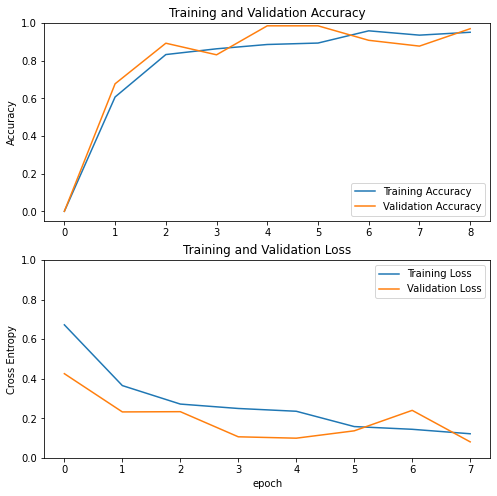

In [86]:
acc = [0.] + model_train.history['accuracy']
val_acc = [0.] + model_train.history['val_accuracy']

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 6. Predictions

Test the predictions made by the Alpaca Model on validation set.

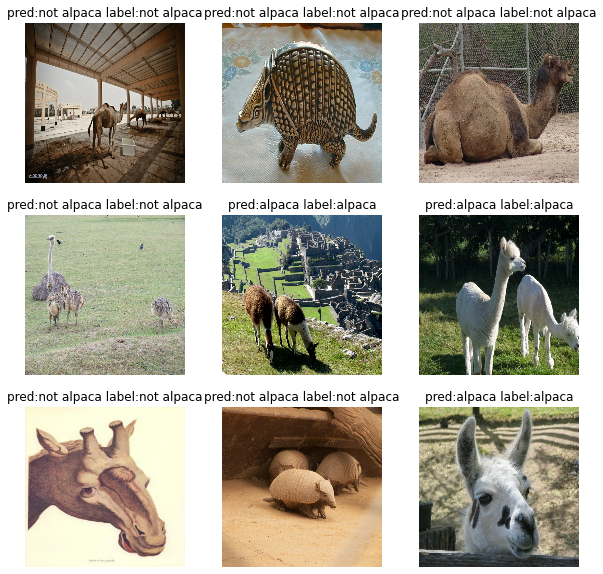

In [87]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    image_var = tf.Variable(images)
    pred = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        p = "alpaca" if pred[i] < 0 else "not alpaca"
        plt.title("pred:{} label:{}".format(p,class_names[labels[i]]))
        plt.axis("off")